## Traffic Sign Recognition(CNN)

### Data Preprocessing

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from skimage import io, color, exposure, transform
from sklearn.model_selection import train_test_split
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
import keras.utils as np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from matplotlib import pyplot as plt

%matplotlib inline

NUM_CLASSES = 43 
IMG_SIZE = 32 

Using TensorFlow backend.


### Data process

Resize to 32x32 and normalizing

In [2]:
import os
from pathlib import PurePath

def preprocess_img(img):
    hsv = color.rgb2hsv(img) 
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)
    
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]
    
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))    
    return img

def get_class(img_path):
    return int(PurePath(img_path).parts[-2])

### Convert image to numpy and label encode with one-hot

In [3]:
try:
    with h5py.File('X.h5') as hf:
        X, Y = hf['imgs'][:], hf['labels'][:]
    
    print("Loaded images from X.h5")
    
except(IOError, OSError, KeyError):
    print("Error in reading X.h5. Processing all images...")
    root_dir = 'GTSRB/Final_Training/Images/'
    imgs = []
    labels = []
    
    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm')) 
    np.random.shuffle(all_img_paths) 
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img) 
            labels.append(label)
            
            if len(imgs)%1000 == 0:
                print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
        except(IOError, OSError):
            print('missed', img_path)
            pass
        
    X = np.array(imgs, dtype='float32') 
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels] 
    
    with h5py.File('X.h5', 'w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

Error in reading X.h5. Processing all images...
Processed 1000/39209
Processed 2000/39209
Processed 3000/39209
Processed 4000/39209
Processed 5000/39209
Processed 6000/39209
Processed 7000/39209
Processed 8000/39209
Processed 9000/39209
Processed 10000/39209
Processed 11000/39209
Processed 12000/39209
Processed 13000/39209
Processed 14000/39209
Processed 15000/39209
Processed 16000/39209
Processed 17000/39209
Processed 18000/39209
Processed 19000/39209
Processed 20000/39209
Processed 21000/39209
Processed 22000/39209
Processed 23000/39209
Processed 24000/39209
Processed 25000/39209
Processed 26000/39209
Processed 27000/39209
Processed 28000/39209
Processed 29000/39209
Processed 30000/39209
Processed 31000/39209
Processed 32000/39209
Processed 33000/39209
Processed 34000/39209
Processed 35000/39209
Processed 36000/39209
Processed 37000/39209
Processed 38000/39209
Processed 39000/39209


## Lenet Model with 6 Convolution, 3 Max Pooling, Flatten and 3 Dense.

In [4]:
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model;   

model = cnn_model() 
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [5]:
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

## Training

In [6]:
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

batch_size = 32
nb_epoch = 30

history = model.fit(X, Y,
         batch_size=batch_size,
         epochs=nb_epoch,
         validation_split=0.2,
         shuffle=True,
         callbacks=[LearningRateScheduler(lr_schedule),
             ModelCheckpoint('model.h5', save_best_only=True)
         ])

Train on 31367 samples, validate on 7842 samples
Epoch 1/30
31367/31367 [==============================] - 10s 308us/step - loss: 2.1683 - acc: 0.3963 - val_loss: 0.6363 - val_acc: 0.7948
Epoch 2/30
31367/31367 [==============================] - 8s 241us/step - loss: 0.3817 - acc: 0.8806 - val_loss: 0.1304 - val_acc: 0.9610
Epoch 3/30
31367/31367 [==============================] - 8s 266us/step - loss: 0.1970 - acc: 0.9397 - val_loss: 0.0942 - val_acc: 0.9722
Epoch 4/30
31367/31367 [==============================] - 8s 259us/step - loss: 0.1422 - acc: 0.9556 - val_loss: 0.0774 - val_acc: 0.9763
Epoch 5/30
31367/31367 [==============================] - 8s 248us/step - loss: 0.1135 - acc: 0.9657 - val_loss: 0.0592 - val_acc: 0.9830
Epoch 6/30
31367/31367 [==============================] - 8s 246us/step - loss: 0.0919 - acc: 0.9721 - val_loss: 0.0586 - val_acc: 0.9839
Epoch 7/30
31367/31367 [==============================] - 8s 257us/step - loss: 0.0802 - acc: 0.9764 - val_loss: 0.0412 - 

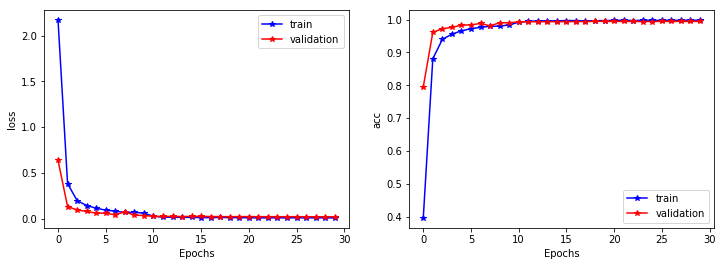

In [7]:
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'b-*')
    plt.plot(history.history.get(val_metrics),'r-*')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.grid()
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')


plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc')


plt.show()

## Evaluation

In [8]:
import pandas as pd
test = pd.read_csv('GTSRB/GT-final_test.csv', sep=';')
X_test = []
y_test = []

i=0
for file_name, class_id in zip(list(test['Filename']),list(test['ClassId'])):
    img_path = os.path.join('GTSRB/Final_Test/Images/',file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_test.shape:  (12630, 32, 32, 3)
y_test.shape:  (12630,)


### Test Accuracy

In [9]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9756927949326999


## Data Augmentation(use ImageDataGenerator)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            rotation_range=10.,
                            width_shift_range=0.1,
                            height_shift_range=0.1,                             
                            shear_range=0.1,
                            zoom_range=0.2,
                            )

datagen.fit(X_train)

In [11]:
model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

batch_size = 32
nb_epoch = 30

history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0]/batch_size,
                            epochs=nb_epoch,
                            validation_data=(X_val, Y_val),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint('model2.h5',save_best_only=True)]
                           )

Epoch 1/30
981/980 [==============================] - 10s 10ms/step - loss: 2.6272 - acc: 0.2432 - val_loss: 1.2090 - val_acc: 0.5896
Epoch 2/30
981/980 [==============================] - 9s 10ms/step - loss: 1.0004 - acc: 0.6764 - val_loss: 0.2747 - val_acc: 0.9074
Epoch 3/30
981/980 [==============================] - 9s 10ms/step - loss: 0.4511 - acc: 0.8548 - val_loss: 0.1306 - val_acc: 0.9554
Epoch 4/30
981/980 [==============================] - 10s 10ms/step - loss: 0.3012 - acc: 0.9056 - val_loss: 0.0613 - val_acc: 0.9790
Epoch 5/30
981/980 [==============================] - 10s 10ms/step - loss: 0.2202 - acc: 0.9307 - val_loss: 0.0437 - val_acc: 0.9869
Epoch 6/30
981/980 [==============================] - 10s 10ms/step - loss: 0.1939 - acc: 0.9398 - val_loss: 0.0407 - val_acc: 0.9878
Epoch 7/30
981/980 [==============================] - 10s 10ms/step - loss: 0.1566 - acc: 0.9509 - val_loss: 0.0334 - val_acc: 0.9889
Epoch 8/30
981/980 [==============================] - 9s 10ms/st

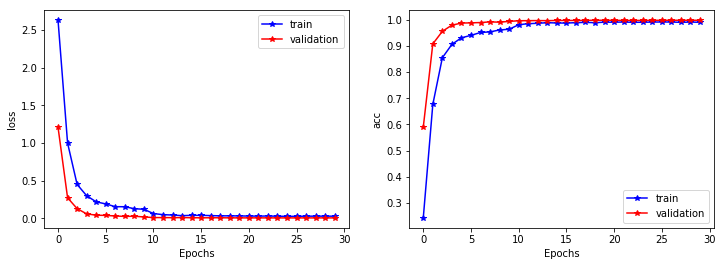

In [12]:
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'b-*')
    plt.plot(history.history.get(val_metrics),'r-*')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.grid()
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')


plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc')


plt.show()

## Evaluation(Data Augmentation)

In [13]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9815518606492478
